In [ ]:
# Install library yang diperlukan
%pip install scikit-learn pandas joblib imblearn xgboost

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [ ]:
# Muat dataset mentah
DATA_FILE_M2 = '/content/rekomind_answer_history (4).csv'
df_raw = pd.read_csv(DATA_FILE_M2)
print("✅ Data mentah dimuat. Jumlah data:", len(df_raw))


✅ Data mentah dimuat. Jumlah data: 1238


In [ ]:
# cek duplikasi data
duplikat_soal = df_raw[df_raw.duplicated(subset=["question_text", "correct_answer", "category_name"], keep=False)]
print("🔁 Jumlah pertanyaan berulang:", len(duplikat_soal))

🔁 Jumlah pertanyaan berulang: 514


In [ ]:
# hapus duplikasi data
df_dedup = df_raw.drop_duplicates(
subset=["question_text", "correct_answer", "category_name"],
keep='first'
)
print(f"✅ Data setelah hapus duplikat: {len(df_dedup)}")

✅ Data setelah hapus duplikat: 944


In [ ]:
# cek duplikasi data
duplikat_soal = df_dedup[df_dedup.duplicated(subset=["question_text", "correct_answer", "category_name"], keep=False)]
print("🔁 Jumlah pertanyaan berulang:", len(duplikat_soal))

🔁 Jumlah pertanyaan berulang: 0


In [ ]:
# Buat fitur numerik untuk kesulitan
difficulty_map = {'easy': 1.0, 'medium': 2.0, 'hard': 3.0}
df_dedup['difficulty_score'] = df_raw['difficulty'].map(difficulty_map).fillna(2.0)


/tmp/ipython-input-7-2110378102.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dedup['difficulty_score'] = df_raw['difficulty'].map(difficulty_map).fillna(2.0)


In [ ]:
# Agregasi per user + kategori
df_grouped = df_dedup.groupby(['user_id', 'category_name']).agg(
    total_questions=('is_correct', 'count'),
    correct_count=('is_correct', 'sum'),
    incorrect_count=('is_correct', lambda x: (~x).sum()),
    accuracy=('is_correct', 'mean'),
    difficulty_score=('difficulty_score', 'mean')
).reset_index()


In [ ]:
# Buat label/target
def classify_accuracy(acc):
    if acc >= 0.8:
        return "Kuat"
    elif acc >= 0.6:
        return "Cukup"
    else:
        return "Lemah"

df_grouped['tingkat_pemahaman'] = df_grouped['accuracy'].apply(classify_accuracy)


In [ ]:
# Drop user_id
df_grouped = df_grouped.drop(columns=['user_id'])


In [ ]:
df_grouped.head()

,category_name,total_questions,correct_count,incorrect_count,accuracy,difficulty_score,tingkat_pemahaman,correct_ratio,interaction,difficulty_correct_ratio
0,Entertainment: Japanese Anime & Manga,12,2,10,0.166667,1.166667,Lemah,0.166667,14.0,0.194444
1,Science: Computers,2,0,2,0.000000,2.000000,Lemah,0.000000,4.0,0.000000
2,Science: Computers,10,5,5,0.500000,2.000000,Lemah,0.500000,20.0,1.000000
3,Science: Computers,3,0,3,0.000000,1.000000,Lemah,0.000000,3.0,0.000000
4,Entertainment: Cartoon & Animations,23,16,7,0.695652,1.913043,Cukup,0.695652,44.0,1.330813


In [ ]:
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   category_name             145 non-null    object 
 1   total_questions           145 non-null    int64  
 2   correct_count             145 non-null    int64  
 3   incorrect_count           145 non-null    int64  
 4   accuracy                  145 non-null    float64
 5   difficulty_score          145 non-null    float64
 6   tingkat_pemahaman         145 non-null    object 
 7   correct_ratio             145 non-null    float64
 8   interaction               145 non-null    float64
 9   difficulty_correct_ratio  145 non-null    float64
dtypes: float64(5), int64(3), object(2)
memory usage: 11.5+ KB


In [ ]:
# Feature Engineering: Tambahkan fitur baru
df_grouped['correct_ratio'] = df_grouped['correct_count'] / df_grouped['total_questions']
df_grouped['interaction'] = df_grouped['total_questions'] * df_grouped['difficulty_score']
df_grouped['difficulty_correct_ratio'] = df_grouped['difficulty_score'] * df_grouped['correct_ratio']


In [ ]:
# Ubah kolom kategori jadi string
df_grouped['category_name'] = df_grouped['category_name'].astype(str)

In [ ]:
# Encoding kolom kategori
cat_encoder = LabelEncoder()
df_grouped["category_name"] = cat_encoder.fit_transform(df_grouped["category_name"])


In [ ]:
# Distribusi kelas
print("\n📊 Distribusi kelas awal:")
print(df_grouped['tingkat_pemahaman'].value_counts())



📊 Distribusi kelas awal:
tingkat_pemahaman
Lemah    90
Kuat     36
Cukup    19
Name: count, dtype: int64


In [ ]:
# Pisahkan fitur dan target
X = df_grouped[["category_name", "total_questions", "difficulty_score",
                    "correct_ratio", "interaction", "difficulty_correct_ratio"]]
y = df_grouped["tingkat_pemahaman"]


In [ ]:
# Hitung class weights
class_counts = y.value_counts()
total_samples = len(y)
class_weights = {
    'Lemah': total_samples / (3 * class_counts['Lemah']),
    'Cukup': total_samples / (3 * class_counts['Cukup']),
    'Kuat': total_samples / (3 * class_counts['Kuat'])
}

print("\n⚖️ Class weights yang dihitung:")
for cls, weight in class_weights.items():
    print(f"{cls}: {weight:.2f}")



⚖️ Class weights yang dihitung:
Lemah: 0.54
Cukup: 2.54
Kuat: 1.34


In [ ]:
# Split data dengan stratify
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

In [ ]:
# Terapkan SMOTE hanya pada data training
print("\n🔁 Menerapkan SMOTE untuk menyeimbangkan kelas...")
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Distribusi kelas setelah SMOTE:")
print(y_train_res.value_counts())



🔁 Menerapkan SMOTE untuk menyeimbangkan kelas...
Distribusi kelas setelah SMOTE:
tingkat_pemahaman
Lemah    63
Cukup    63
Kuat     63
Name: count, dtype: int64


In [ ]:
# Scaling data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# 1. Hyperparameter Tuning untuk Random Forest
print("\n🔎 Melakukan Hyperparameter Tuning untuk Random Forest...")



🔎 Melakukan Hyperparameter Tuning untuk Random Forest...


In [ ]:
# Buat mapping kelas ke integer
class_mapping = {'Cukup': 0, 'Kuat': 1, 'Lemah': 2}
y_train_numeric = y_train_res.map(class_mapping)


In [ ]:
# PERBAIKAN: Gunakan class_weight='balanced' untuk menghindari masalah format
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample']  # Gunakan opsi built-in
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train_numeric)

print("\n🎯 Best Parameters for Random Forest:")
print(grid_search.best_params_)
print("Best F1 Macro Score:", grid_search.best_score_)

best_rf = grid_search.best_estimator_


Fitting 5 folds for each of 108 candidates, totalling 540 fits

🎯 Best Parameters for Random Forest:
{'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best F1 Macro Score: 0.983844155844156


In [ ]:
# 2. XGBoost dengan Bobot Kelas
print("\n🚀 Melatih XGBoost dengan Bobot Kelas...")
# Hitung scale_pos_weight untuk XGBoost
scale_weights = {
    'Cukup': class_counts['Lemah']/class_counts['Cukup'],
    'Kuat': class_counts['Lemah']/class_counts['Kuat'],
    'Lemah': 1.0
}

y_test_numeric = y_test.map(class_mapping)

xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    scale_pos_weight=[scale_weights['Cukup'], scale_weights['Kuat'], scale_weights['Lemah']],
    random_state=42,
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8
)

xgb.fit(X_train_scaled, y_train_numeric)



🚀 Melatih XGBoost dengan Bobot Kelas...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:32:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

In [ ]:
# 3. Ensemble Model dengan Voting Classifier
print("\n🤝 Membuat Ensemble Model...")



🤝 Membuat Ensemble Model...


In [ ]:
# Gunakan model Random Forest terbaik dengan class_weight built-in
# SVM dengan bobot kelas 'balanced'
svm = SVC(
    probability=True,
    class_weight='balanced',  # Gunakan balanced untuk menghindari masalah
    random_state=42,
    kernel='rbf',
    C=1.0,
    gamma='scale'
)

In [ ]:
# Buat ensemble model
ensemble = VotingClassifier(
    estimators=[
        ('rf', best_rf),
        ('xgb', xgb),
        ('svm', svm)
    ],
    voting='soft',  # Gunakan soft voting untuk probabilitas
    n_jobs=-1
)

# Latih ensemble dengan target string asli
ensemble.fit(X_train_scaled, y_train_res)


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=5,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=N...
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=5,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_class=3, num_parallel_tree=None, ...)),
                             ('svm',
                              SVC(class_weight='balanced', probability=True,
                                  random_state=42))],
                 n_jobs=-1, voting='soft')

In [ ]:
# 4. Evaluasi Ensemble Model
print("\n📊 Evaluasi Ensemble Model:")



📊 Evaluasi Ensemble Model:


In [ ]:
# Prediksi
y_pred = ensemble.predict(X_test_scaled)

In [ ]:
print("\n===== Ensemble Model Performance =====")
print("✅ Akurasi:", accuracy_score(y_test, y_pred))
print("✅ Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("✅ F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))
print("📉 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


===== Ensemble Model Performance =====
✅ Akurasi: 1.0
✅ Balanced Accuracy: 1.0
✅ F1 Score (macro): 1.0

📊 Classification Report:
               precision    recall  f1-score   support

       Cukup       1.00      1.00      1.00         6
        Kuat       1.00      1.00      1.00        11
       Lemah       1.00      1.00      1.00        27

    accuracy                           1.00        44
   macro avg       1.00      1.00      1.00        44
weighted avg       1.00      1.00      1.00        44

📉 Confusion Matrix:
 [[ 6  0  0]
 [ 0 11  0]
 [ 0  0 27]]


In [ ]:
print("\n===== XGBoost Performance =====")
xgb_pred = xgb.predict(X_test_scaled)
xgb_pred_labels = [list(class_mapping.keys())[list(class_mapping.values()).index(val)] for val in xgb_pred]

print("✅ Akurasi:", accuracy_score(y_test, xgb_pred_labels))
print("✅ Balanced Accuracy:", balanced_accuracy_score(y_test, xgb_pred_labels))
print("✅ F1 Score (macro):", f1_score(y_test, xgb_pred_labels, average='macro'))
print("\n📊 Classification Report:\n", classification_report(y_test, xgb_pred_labels))



===== XGBoost Performance =====
✅ Akurasi: 1.0
✅ Balanced Accuracy: 1.0
✅ F1 Score (macro): 1.0

📊 Classification Report:
               precision    recall  f1-score   support

       Cukup       1.00      1.00      1.00         6
        Kuat       1.00      1.00      1.00        11
       Lemah       1.00      1.00      1.00        27

    accuracy                           1.00        44
   macro avg       1.00      1.00      1.00        44
weighted avg       1.00      1.00      1.00        44



Text(0.5, 1.0, 'Confusion Matrix - Ensemble Model')

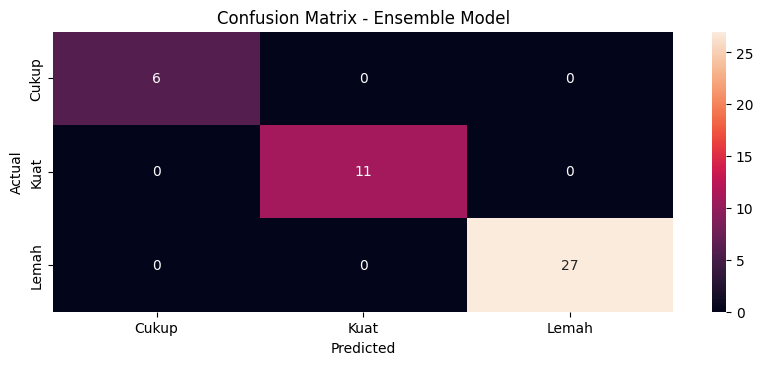

In [ ]:
# Visualisasi Confusion Matrix untuk Ensemble
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt="d", cmap="rocket",
            xticklabels=["Cukup", "Kuat", "Lemah"],
            yticklabels=["Cukup", "Kuat", "Lemah"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Ensemble Model")


Text(0.5, 1.0, 'Confusion Matrix - XGBoost')

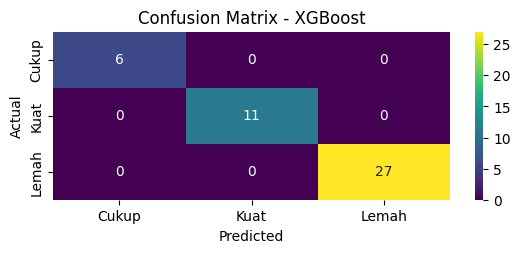

In [ ]:
# Visualisasi Confusion Matrix untuk XGBoost
plt.subplot(2, 1, 2)
sns.heatmap(confusion_matrix(y_test, xgb_pred_labels),
            annot=True, fmt="d", cmap="viridis",
            xticklabels=["Cukup", "Kuat", "Lemah"],
            yticklabels=["Cukup", "Kuat", "Lemah"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")


In [ ]:
plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>

In [ ]:
# Simpan model dan komponen
joblib.dump(ensemble, "ensemble_model_reko.pkl")
joblib.dump(xgb, "xgb_model_reko.pkl")
joblib.dump(scaler, "scaler_enhanced.pkl")
joblib.dump(cat_encoder, "category_encoder.pkl")
joblib.dump(class_mapping, "class_mapping.pkl")  # Simpan mapping kelas

['class_mapping.pkl']

In [ ]:
print("\n💾 Model dan komponen berhasil disimpan:")
print("- ensemble_model_reko.pkl (Voting Classifier)")
print("- xgb_model_reko.pkl (XGBoost Model)")
print("- scaler_enhanced.pkl")
print("- category_encoder.pkl")
print("- class_mapping.pkl (Class mapping)")


💾 Model dan komponen berhasil disimpan:
- ensemble_model_reko.pkl (Voting Classifier)
- xgb_model_reko.pkl (XGBoost Model)
- scaler_enhanced.pkl
- category_encoder.pkl
- class_mapping.pkl (Class mapping)


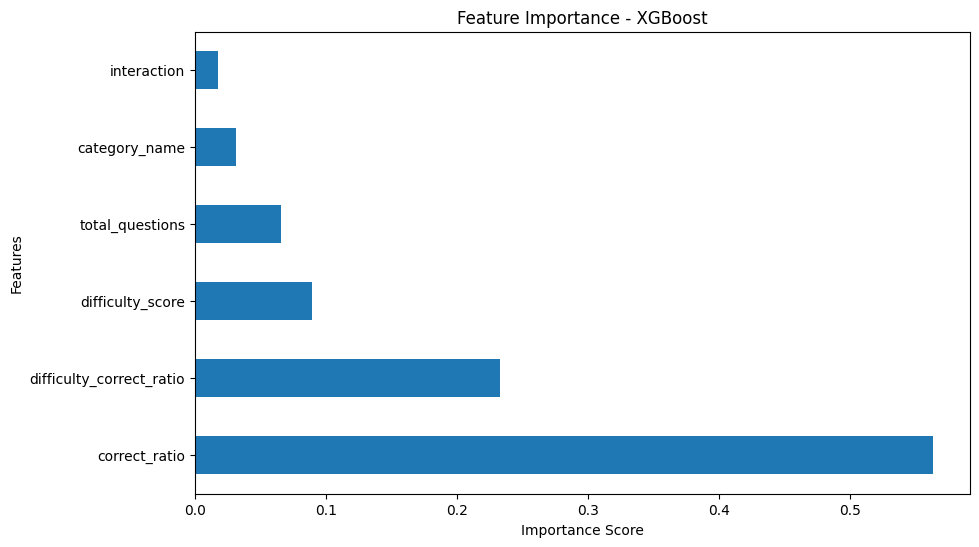

In [ ]:
# Feature Importance dari XGBoost
plt.figure(figsize=(10, 6))
feature_importances = pd.Series(xgb.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importance - XGBoost')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

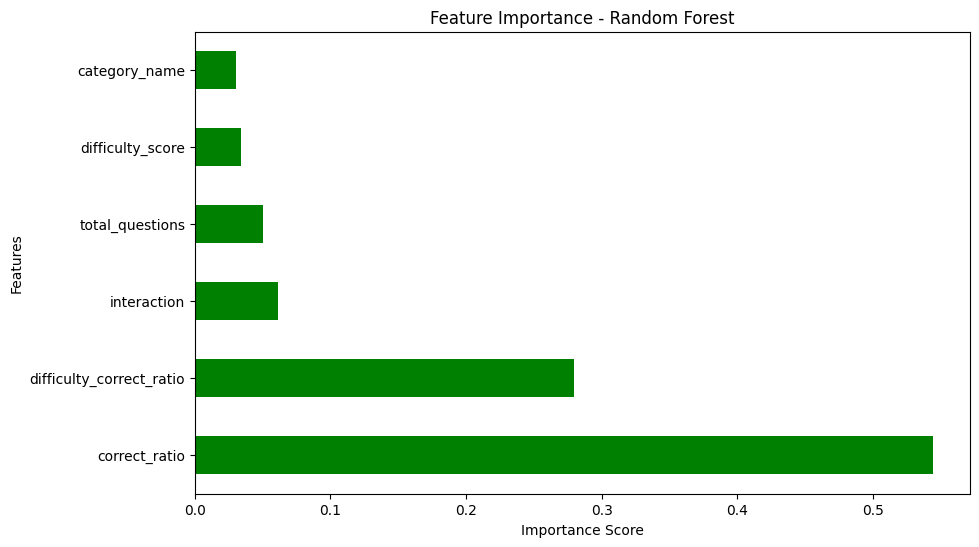

In [ ]:
# Feature Importance dari Random Forest
rf_importances = pd.Series(best_rf.feature_importances_, index=X.columns)
plt.figure(figsize=(10, 6))
rf_importances.nlargest(10).plot(kind='barh', color='green')
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()